# `tesscube` Tutorial

NASA TESS data is available to users as either 

- Time series (Light Curve Files)
- Pixel level data, cut out around astrophysical targets (Target Pixel Files)
- Pixel level data from an entire camera sensors (Full Frame Image Files).

TESS Full Frame Image data is available as cubes stored in the cloud by MAST.

`tesscube` enables you to work with these cubes both on your local machine and in amazon AWS instances (e.g. TiKE). `tesscube` will enable you to work with the cube data without explicitly downloading it to your machine, and will help you cut TPFs out of the data. 

:::note

**Note:** `tesscube` will always return `astropy` objects, such as `astropy.wcs.WCS` objects, or `astropy.fits.HDUList` objects. You can use the `astropy` documentation to understand more about how those Python objects work. 

:::

:::note

**Note:** `tesscube` will never store any TESS data files to disk, it will only store them in memory. If you want to store them on disk, you will need to write them.

:::


In [1]:
from tesscube import TESSCube
import matplotlib.pyplot as plt

You can obtain a cube using `TESSCube`

In [2]:
cube = TESSCube(sector=38, camera=1, ccd=1)

In [3]:
cube

TESSCube [Sector 38, Camera 1, CCD 1]

This cube has not been downloaded (that would be terrabytes of data!), but this object will go and retrieve pieces of the data for you. The object has access to useful meta data about the cube e.g. sector

In [4]:
cube.sector

38

camera and CCD number

In [5]:
cube.camera, cube.ccd

(1, 1)

The shape of the cube in format `(nframes, nrows, ncolumns)`

In [6]:
cube.shape

(3705, 2078, 2136)

The file names of the FFIs that went into the cubes

In [7]:
cube.ffi_names[:10]

['tess2021119082905-s0038-1-1-0209-s_ffic.fits',
 'tess2021119083905-s0038-1-1-0209-s_ffic.fits',
 'tess2021119084905-s0038-1-1-0209-s_ffic.fits',
 'tess2021119085905-s0038-1-1-0209-s_ffic.fits',
 'tess2021119090905-s0038-1-1-0209-s_ffic.fits',
 'tess2021119091905-s0038-1-1-0209-s_ffic.fits',
 'tess2021119092905-s0038-1-1-0209-s_ffic.fits',
 'tess2021119093905-s0038-1-1-0209-s_ffic.fits',
 'tess2021119094905-s0038-1-1-0209-s_ffic.fits',
 'tess2021119095905-s0038-1-1-0209-s_ffic.fits']

A WCS

In [8]:
cube.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 213.32687183933797  -39.21957236544086  
CRPIX : 1045.0  1001.0  
CD1_1 CD1_2  : 0.005191266669209171  0.002238086088774782  
CD2_1 CD2_2  : -0.002370891851994  0.005249526134504192  
NAXIS : 2136.0  2078.0

And the cadence number and times associated with the FFI

In [9]:
cube.cadence_number

array([   1,    2,    3, ..., 3842, 3843, 3844])

In [10]:
cube.time

array([2333.86306818, 2333.87001266, 2333.87695715, ..., 2360.53641726,
       2360.54336149, 2360.55030573])

## Accessing FFI Data

The cube data has format `(nframes, nrows, ncolumns)`. You can index into a `TESSCube` to access the information inside it. If you access an index in the time dimension, you will obtain an FFI. For example, we can get the 300th FFI in this cube:

In [11]:
ffi = cube[300]

In [12]:
ffi

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x127ed2d30>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1688336d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x168833820>]

This has returned an `astropy.fits.HDUList` object. Let's look at it

In [13]:
ffi.info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  CAMERA.CCD 1.1 cal    1 ImageHDU       183   (2136, 2078)   float32   
  2  CAMERA.CCD 1.1 uncert    1 ImageHDU       183   (2136, 2078)   float32   


This fits file has two image HDUs, one for the data and one for the pipeline estimated uncertainties. We can plot this data.

[Text(0.5, 0, 'Column [pix]'),
 Text(0, 0.5, 'Row [pix]'),
 Text(0.5, 1.0, 'FFI Sector 38, Camera 1, CCD 1')]

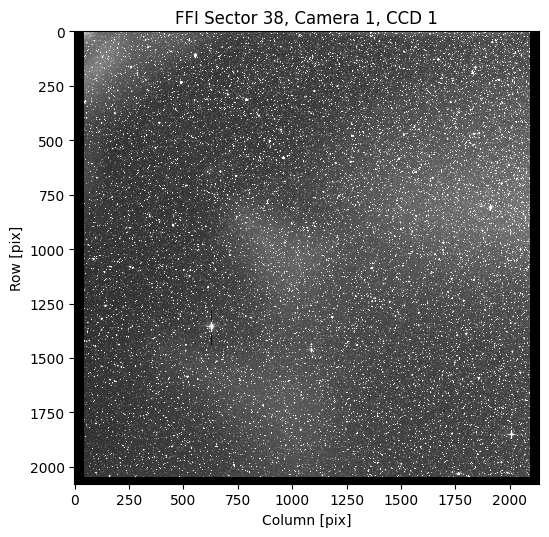

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(ffi[1].data, vmin=0, vmax=1000, cmap="Greys_r", interpolation="nearest")
ax.set(
    xlabel="Column [pix]",
    ylabel="Row [pix]",
    title=f"FFI Sector {cube.sector}, Camera {cube.camera}, CCD {cube.ccd}",
)

This is useful if you want to see the full output of the camera, but keep in mind FFIs are large files, and trying to access many of them may take while.

## Accessing TPFs

TPFs are "Target Pixel Files". We can generate a TPF using `tesscube`. Let's first imagine we want to cut out a specific pixel range.

In [15]:
tpf = cube[:, 400:410, 400:411]

In [16]:
tpf

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1304c58b0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1304c07c0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x137b2ec70>]

This TPF is also a fits object, which is an `astropy.fits.HDUList`. We can look at it

In [17]:
tpf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      40   ()      
  1  PIXELS        1 BinTableHDU    237   3705R x 11C   ['D', 'E', 'I', '110E', '110E', '110E', '110E', '110E', 'J', 'E', 'E']   
  2  APERTURE      1 ImageHDU        50   (11, 10)   float64   


This has a different format to the FFI, this has a table of pixel values.

TPFs have a standardized structure from the TESS mission. We can access the flux data in the first extension.

[Text(0.5, 0, 'Column [pix]'),
 Text(0, 0.5, 'Row [pix]'),
 Text(0.5, 1.0, 'TPF Sector 38, Camera 1, CCD 1')]

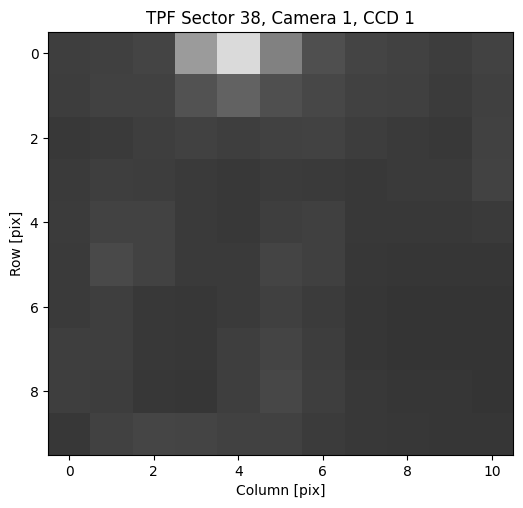

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(
    tpf[1].data["FLUX"][300], vmin=0, vmax=1000, cmap="Greys_r", interpolation="nearest"
)
ax.set(
    xlabel="Column [pix]",
    ylabel="Row [pix]",
    title=f"TPF Sector {cube.sector}, Camera {cube.camera}, CCD {cube.ccd}",
)

It looks like there's not much interesting in this TPF, which is expected as we picked out a random subset of the sky.

Let's look at the shape of the data

In [19]:
tpf[1].data["FLUX"].shape

(3705, 10, 11)

If we want to, we can cut out a small frame range of the data. 

:::warning

This is an inefficient operation. The data cubes are designed to be sliced in space, rather than time. Requesting a sliced version of time requires one query per time stamp. If you want more than ~20 frames and only a small number of pixels it will likely be faster to download the whole dataset. If you want only a few frames, and a large number of pixels, using time slicing will be more efficient.

:::

In [20]:
tpf_short = cube[400:405, 400:410, 400:411]

In [21]:
tpf_short[1].data["FLUX"].shape

(5, 10, 11)

This has cut down the data size to only the 5 frames we requested.

Finally, if we want to, we can downsample the data. We do this with slicing, as show below. Here we are downsampling the data by a factor of 10.

In [22]:
tpf_low_time_res = cube[::10, 400:410, 400:411]

In [23]:
tpf_low_time_res[1].data["FLUX"].shape

(370, 10, 11)

This has resulted in a dataset with a lower time resolution. If you plot the comparision, you will see there are fewer time stamps, but the flux is higher as it has been summed.

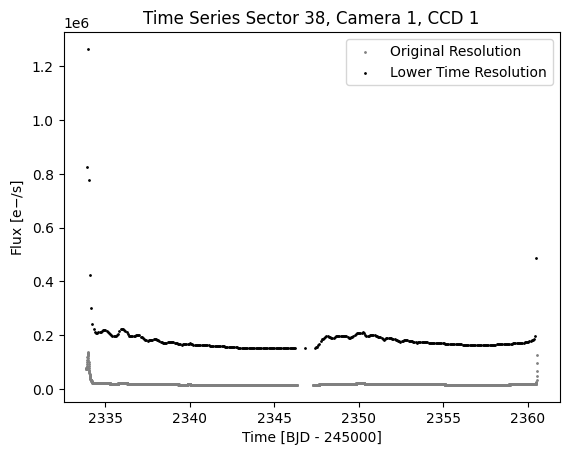

In [24]:
fig, ax = plt.subplots()
ax.scatter(
    tpf[1].data["TIME"],
    tpf[1].data["FLUX"].sum(axis=(1, 2)),
    c="grey",
    s=1,
    label="Original Resolution",
)
ax.scatter(
    tpf_low_time_res[1].data["TIME"],
    tpf_low_time_res[1].data["FLUX"].sum(axis=(1, 2)),
    c="k",
    s=1,
    label="Lower Time Resolution",
)
ax.legend()
ax.set(
    xlabel="Time [BJD - 245000]",
    ylabel="Flux [e$-$/s]",
    title=f"Time Series Sector {cube.sector}, Camera {cube.camera}, CCD {cube.ccd}",
);

You can also access the position corrections for your target. If you index into the cube to get a TPF, the position correction will be estimated using the TPF center.

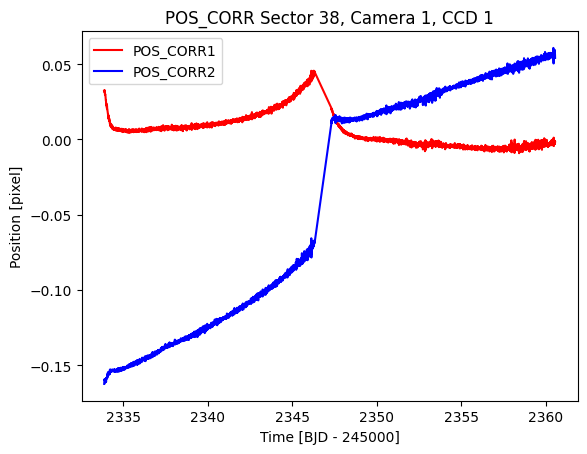

In [25]:
fig, ax = plt.subplots()
ax.plot(tpf[1].data["TIME"], tpf[1].data["POS_CORR1"], c="r", label="POS_CORR1")
ax.plot(tpf[1].data["TIME"], tpf[1].data["POS_CORR2"], c="b", label="POS_CORR2")
ax.legend()
ax.set(
    xlabel="Time [BJD - 245000]",
    ylabel="Position [pixel]",
    title=f"POS_CORR Sector {cube.sector}, Camera {cube.camera}, CCD {cube.ccd}",
);

## Getting a TPF for a target

Often you will have a target you want to obtain TESS data for. You can use `tesscube` to find the data for a particular astronomical target. Let's assume we want to find the target AU Mic. First we will create an `astropy.coordinates.SkyCoord` object which contains the RA and Dec of our target.

In [26]:
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

coord = SkyCoord.from_name("AU Mic")

In [27]:
coord

<SkyCoord (ICRS): (ra, dec) in deg
    (311.28971874, -31.34089941)>

Now we can find the data. If we do not know the particular camera and CCD the data falls on we can use `tesscube` to find the right cube:

In [28]:
cube = TESSCube.from_skycoord(coord, sector=1)

Alternatively, we can initialize with a known camera and CCD

In [29]:
cube = TESSCube(sector=1, camera=1, ccd=4)

Now we can object a TPF of our coordinate

In [30]:
tpf = cube.get_tpf(coord, shape=(30, 36), frame_bin=4)

Here I have obtained a TPF with shape 30 rows by 36 pixels, and I have downsampled the time resolution by a factor of 4. 

I can obtain the column and row position that the source will fall on using the WCS

In [31]:
column, row = WCS(tpf[2]).world_to_pixel(coord)

[Text(0.5, 0, 'TPF Column [pix]'),
 Text(0, 0.5, 'TPF Row [pix]'),
 Text(0.5, 1.0, 'AU Mic Sector 1, Camera 1, CCD 4')]

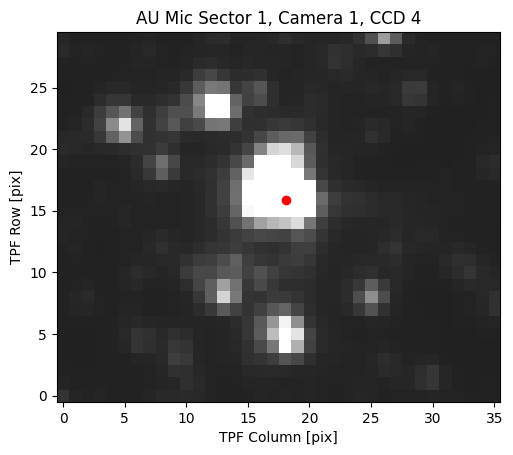

In [32]:
fig, ax = plt.subplots()
ax.imshow(tpf[1].data["FLUX"][100], vmin=0, vmax=5000, origin="lower", cmap="Greys_r")
ax.scatter(column, row, c="r")
ax.set(
    xlabel="TPF Column [pix]",
    ylabel="TPF Row [pix]",
    title=f"AU Mic Sector {cube.sector}, Camera {cube.camera}, CCD {cube.ccd}",
)

We can see that we now have the data for AU Mic.